In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import tensorflow as tf
from numpy import *
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from tensorflow.keras import layers,datasets
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler
from tensorflow import keras
import gc
# import warnings
# warnings.filterwarnings('ignore')
import lightgbm as lgb
import category_encoders as ce
from sklearn.metrics import f1_score,classification_report,roc_auc_score
from impala.dbapi import connect
from impala.util import as_pandas
import pymysql

In [2]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [3]:
def get_game_id():
    conn = pymysql.connect(host='192.168.0.79', port=3306, user='readonly',
                           passwd='Kc&r+z1ql9x8za4kzfk761weq8ozGv3ZpI;RMe,#+s%c>t')
    cur = conn.cursor(cursor=pymysql.cursors.DictCursor)
    sql = '''
        SELECT dev_game_id AS game_id FROM db_data.t_game_config WHERE game_id = 1056 AND dev_game_id IS NOT NULL 
    '''
    cur.execute(sql)
    result_df = cur.fetchall()
    cur.close()
    conn.close()
    return result_df

In [4]:
# 获取近期所有计划('2021年4月23号开始')
def get_plan_info():
    game_id = get_game_id()
    game_id = list(map(lambda x: x['game_id'], game_id))
    game_id = [str(i) for i in game_id]
    game_id = ','.join(game_id)
    conn = pymysql.connect(host='192.168.0.65', port=3306, user='readonly',
                           passwd='Kc&r+z1ql9x8za4kzfk761weq8ozGv3ZpI;RMe,#+s%c>t', db='db_ptom')
    cur = conn.cursor(cursor=pymysql.cursors.DictCursor)
    sql = '''
    /*手动查询*/
        SELECT
                * 
            FROM
                db_ptom.ptom_third_plan p
            WHERE
                game_id IN ({})
                AND media_id = 10
                AND create_time>='2021-04-23'
                AND create_time<= date(NOW())
                            AND plan_id >= (
                                select plan_id from db_ptom.ptom_plan
                                where create_time >= '2021-04-23'
                                and create_time <= '2021-04-24'
                                limit 1
                            )
    '''
    finalSql = sql.format(game_id)
    result_df = pd.read_sql(finalSql, conn)
    cur.close()
    conn.close()
    return result_df

In [5]:
# 获取image_id,label_ids
def get_image_info():
    conn = pymysql.connect(host='192.168.0.79', port=3306, user='readonly',
                        passwd='Kc&r+z1ql9x8za4kzfk761weq8ozGv3ZpI;RMe,#+s%c>t')
    cur = conn.cursor(cursor=pymysql.cursors.DictCursor)
    sql = '''
        SELECT
            a.chl_user_id AS channel_id,
            a.source_id,
            a.image_id,
            b.label_ids
        FROM
            db_data_ptom.ptom_plan a
            LEFT JOIN
            db_data_ptom.ptom_image_info b
        on a.image_id = b.image_id
        WHERE
            a.game_id IN ( SELECT dev_game_id AS game_id FROM db_data.t_game_config WHERE game_id = 1056 AND dev_game_id IS NOT NULL ) 
            AND a.media_id = 10 
            AND a.create_time >= '2021-03-14' 
        GROUP BY
            a.chl_user_id,
            a.source_id,
            a.image_id
    '''
    cur.execute(sql)
    result_df = pd.read_sql(sql, conn)
    cur.close()
    conn.close()
    return result_df

In [6]:
def get_launch_report():
    game_id = get_game_id()
    game_id = list(map(lambda x: x['game_id'], game_id))
    game_id = [str(i) for i in game_id]
    game_id = ','.join(game_id)

    conn = pymysql.connect(host='192.168.0.79', port=3306, user='readonly',
                           passwd='Kc&r+z1ql9x8za4kzfk761weq8ozGv3ZpI;RMe,#+s%c>t')
    cur = conn.cursor(cursor=pymysql.cursors.DictCursor)
    sql = '''
        /*手动查询*/
        SELECT
            a.chl_user_id AS channel_id,
            a.source_id AS source_id,
            b.tdate,
            b.amount,
            b.new_role_money,
            b.new_role_money / b.amount as roi,
            b.pay_role_user_num / b.create_role_num as pay_rate
        FROM
            db_data_ptom.ptom_plan a
            LEFT JOIN db_stdata.st_lauch_report b ON a.chl_user_id = b.channel_id 
            AND a.source_id = b.source_id 
        WHERE
            a.create_time >= '2021-04-23' 
            AND b.tdate >= '2021-04-23' 
            AND b.tdate_type = 'day' 
            AND b.media_id = 10
            AND b.game_id IN ({})
            AND b.amount >= 500
    '''
    finalSql = sql.format(game_id)
    cur.execute(finalSql)
    result_df = pd.read_sql(finalSql, conn)
    cur.close()
    conn.close()
    result_df['tdate'] = pd.to_datetime(result_df['tdate'])
    result_df = result_df.sort_values('tdate')
    result_df = result_df.drop_duplicates(['channel_id', 'source_id'], keep='first')

    return result_df

In [7]:
# 获取近期账号维度窗口期统计数据
def getAdData(conn, begin, end, n):
    originSql = '''
              SELECT
                a.ad_account_id AS 'ad_account_id',
                ifnull( a.ad_amount, 0 ) AS 'ad_amount',
                ifnull( a.ad_create_role_num, 0 ) AS 'ad_create_role_num',
                ifnull( a.ad_new_role_money, 0 ) AS 'ad_new_role_money',
                ifnull( a.ad_pay_role_user_num, 0 ) AS 'ad_pay_role_user_num',
                ifnull( a.ad_source_num, 0 ) AS 'ad_source_num',
                IFNULL( b.ad_valid_source_num, 0 ) AS 'ad_valid_source_num',
                (
                CASE
                        
                        WHEN ifnull( a.ad_create_role_num, 0 )= 0 THEN
                        0 ELSE IFNULL( a.ad_pay_role_user_num, 0 ) / ifnull( a.ad_create_role_num, 0 ) 
                    END 
                    ) AS 'ad_pay_rate',
                    (
                    CASE
                            
                            WHEN ifnull( a.ad_create_role_num, 0 )= 0 THEN
                            0 ELSE IFNULL( a.ad_amount, 0 ) / ifnull( a.ad_create_role_num, 0 ) 
                        END 
                        ) AS 'ad_create_role_cost',
                        (
                        CASE
                                
                                WHEN ifnull( a.ad_pay_role_user_num, 0 )= 0 THEN
                                0 ELSE IFNULL( a.ad_amount, 0 ) / ifnull( a.ad_pay_role_user_num, 0 ) 
                            END 
                            ) AS 'ad_create_role_pay_cost',
                            (
                            CASE
                                    
                                    WHEN ifnull( a.ad_source_num, 0 )= 0 THEN
                                    0 ELSE IFNULL( b.ad_valid_source_num, 0 ) / ifnull( a.ad_source_num, 0 ) 
                                END 
                                ) AS 'ad_valid_source_rate',
                                (
                                CASE
                                        
                                        WHEN ifnull( a.ad_amount, 0 )= 0 THEN
                                        0 ELSE IFNULL( a.ad_new_role_money, 0 ) / ifnull( a.ad_amount, 0 ) 
                                    END 
                                    ) AS 'ad_create_role_roi' 
                                FROM
                                    (
                                    SELECT
                                        a.ad_account_id,
                                        ifnull( sum( a.amount ), 0 ) AS 'ad_amount',
                                        ifnull( sum( a.create_role_num ), 0 ) AS 'ad_create_role_num',
                                        ifnull( sum( b.new_role_money ), 0 ) AS 'ad_new_role_money',
                                        ifnull( sum( b.pay_role_user_num ), 0 ) AS 'ad_pay_role_user_num',
                                        count( DISTINCT a.source_id ) AS 'ad_source_num' 
                                    FROM
                                        (
                                        SELECT
                                            b.ad_account_id,
                                            b.doc_id,
                                            a.game_id,
                                            a.channel_id,
                                            a.source_id,
                                            a.amount,
                                            a.create_role_num 
                                        FROM
                                            db_stdata.st_lauch_report a
                                            INNER JOIN db_data_ptom.ptom_plan b ON a.game_id = b.game_id 
                                            AND a.source_id = b.source_id 
                                            AND a.channel_id = b.chl_user_id 
                                        WHERE
                                            a.tdate_type = 'day' 
                                            AND a.tdate >= '{begin}' 
                                            AND a.tdate <= '{end}' AND a.amount > 100 
                                            AND a.media_id = 10 
                                        AND a.game_id IN ( SELECT dev_game_id AS game_id FROM db_data.t_game_config WHERE game_id = 1056 AND dev_game_id IS NOT NULL )) a
                                        LEFT JOIN (
                                        SELECT
                                            c.game_id,
                                            c.channel_id,
                                            c.source_id,
                                            b.ad_account_id,
                                            sum( c.create_role_money ) new_role_money,
                                            IFNULL( sum( c.pay_role_user_num ), 0 ) AS pay_role_user_num 
                                        FROM
                                            db_stdata.st_game_days c
                                            INNER JOIN db_data_ptom.ptom_plan b ON c.game_id = b.game_id 
                                            AND c.source_id = b.source_id 
                                            AND c.channel_id = b.chl_user_id 
                                        WHERE
                                            c.report_days = {n} 
                                            AND c.tdate = '{end}' 
                                            AND c.tdate_type = 'day' 
                                            AND c.query_type = 13 
                                            AND c.game_id IN ( SELECT dev_game_id AS game_id FROM db_data.t_game_config WHERE game_id = 1056 AND dev_game_id IS NOT NULL ) 
                                        GROUP BY
                                            c.game_id,
                                            c.channel_id,
                                            c.source_id 
                                        HAVING
                                            ( new_role_money > 0 OR pay_role_user_num > 0 ) 
                                        ) b ON a.source_id = b.source_id 
                                        AND a.channel_id = b.channel_id 
                                    GROUP BY
                                        a.ad_account_id 
                                    ) a
                                    LEFT JOIN (
                                    SELECT
                                        b.ad_account_id,
                                        count( DISTINCT b.plan_id ) AS 'ad_valid_source_num' 
                                    FROM
                                        db_stdata.st_lauch_report a
                                        INNER JOIN db_data_ptom.ptom_plan b ON a.game_id = b.game_id 
                                        AND a.source_id = b.source_id 
                                        AND a.channel_id = b.chl_user_id 
                                    WHERE
                                        a.tdate_type = 'day' 
                                        AND a.tdate >= '{begin}' 
                                        AND a.tdate <= '{end}' AND a.amount > 100  
                                        AND a.media_id = 10 
                                        AND a.game_id IN ( SELECT dev_game_id AS game_id FROM db_data.t_game_config WHERE game_id = 1056 AND dev_game_id IS NOT NULL ) 
                                        AND a.pay_role_user_num > 0 
                                    GROUP BY
                                    b.ad_account_id 
                ) b ON A.ad_account_id = B.ad_account_id
    '''
    finalSql = originSql.format(begin=begin, end=end, n=n)
    result = pd.read_sql(finalSql, conn)
    return result

In [8]:
# 获取素材报表数据
def getImData(conn, begin, end, n):
    originSql = '''
            SELECT
                a.image_id AS 'image_id',
                ifnull( a.im_amount, 0 ) AS 'im_amount',
                ifnull( a.im_create_role_num, 0 ) AS 'im_create_role_num',
                ifnull( a.im_new_role_money, 0 ) AS 'im_new_role_money',
                ifnull( a.im_pay_role_user_num, 0 ) AS 'im_pay_role_user_num',
                ifnull( a.im_source_num, 0 ) AS 'im_source_num',
                IFNULL( b.im_valid_source_num, 0 ) AS 'im_valid_source_num',
                (
                CASE
                        
                        WHEN ifnull( a.im_create_role_num, 0 )= 0 THEN
                        0 ELSE IFNULL( a.im_pay_role_user_num, 0 ) / ifnull( a.im_create_role_num, 0 ) 
                    END 
                    ) AS 'im_pay_rate',
                    (
                    CASE
                            
                            WHEN ifnull( a.im_create_role_num, 0 )= 0 THEN
                            0 ELSE IFNULL( a.im_amount, 0 ) / ifnull( a.im_create_role_num, 0 ) 
                        END 
                        ) AS 'im_create_role_cost',
                        (
                        CASE
                                
                                WHEN ifnull( a.im_pay_role_user_num, 0 )= 0 THEN
                                0 ELSE IFNULL( a.im_amount, 0 ) / ifnull( a.im_pay_role_user_num, 0 ) 
                            END 
                            ) AS 'im_create_role_pay_cost',
                            (
                            CASE
                                    
                                    WHEN ifnull( a.im_source_num, 0 )= 0 THEN
                                    0 ELSE IFNULL( b.im_valid_source_num, 0 ) / ifnull( a.im_source_num, 0 ) 
                                END 
                                ) AS 'im_valid_source_rate',
                                (
                                CASE
                                        
                                        WHEN ifnull( a.im_amount, 0 )= 0 THEN
                                        0 ELSE IFNULL( a.im_new_role_money, 0 ) / ifnull( a.im_amount, 0 ) 
                                    END 
                                    ) AS 'image_create_role_roi' 
                                FROM
                                    (
                                    SELECT
                                        a.image_id,
                                        ifnull( sum( a.amount ), 0 ) AS 'im_amount',
                                        ifnull( sum( a.create_role_num ), 0 ) AS 'im_create_role_num',
                                        ifnull( sum( b.new_role_money ), 0 ) AS 'im_new_role_money',
                                        ifnull( sum( b.pay_role_user_num ), 0 ) AS 'im_pay_role_user_num',
                                        count( DISTINCT a.source_id ) AS 'im_source_num' 
                                    FROM
                                        (
                                        SELECT
                                            b.image_id,
                                            a.game_id,
                                            a.channel_id,
                                            a.source_id,
                                            a.amount,
                                            a.create_role_num 
                                        FROM
                                            db_stdata.st_lauch_report a
                                            INNER JOIN db_data_ptom.ptom_plan b ON a.game_id = b.game_id 
                                            AND a.source_id = b.source_id 
                                            AND a.channel_id = b.chl_user_id                                        
                                        WHERE
                                            a.tdate_type = 'day' 
                                            AND a.tdate >= '{begin}' 
                                            AND a.tdate <= '{end}' AND a.amount > 100 
                                            AND b.image_id IS NOT NULL 
                                            AND b.image_id <> '' 
                                            AND a.media_id = 10 
                                        AND a.game_id IN ( SELECT dev_game_id AS game_id FROM db_data.t_game_config WHERE game_id = 1056 AND dev_game_id IS NOT NULL )) a
                                        LEFT JOIN (
                                        SELECT
                                            c.game_id,
                                            c.channel_id,
                                            c.source_id,
                                            b.image_id,
                                            sum( c.create_role_money ) new_role_money,
                                            IFNULL( sum( c.pay_role_user_num ), 0 ) AS pay_role_user_num 
                                        FROM
                                            db_stdata.st_game_days c
                                            INNER JOIN db_data_ptom.ptom_plan b ON c.game_id = b.game_id 
                                            AND c.source_id = b.source_id 
                                            AND c.channel_id = b.chl_user_id 
                                        WHERE
                                            c.report_days = {n} 
                                            AND c.tdate = '{end}' 
                                            AND c.tdate_type = 'day' 
                                            AND c.query_type = 13 
                                            AND b.image_id IS NOT NULL 
                                            AND b.image_id <> '' 
                                            AND c.game_id IN ( SELECT dev_game_id AS game_id FROM db_data.t_game_config WHERE game_id = 1056 AND dev_game_id IS NOT NULL ) 
                                        GROUP BY
                                            c.game_id,
                                            c.channel_id,
                                            c.source_id 
                                        HAVING
                                            ( new_role_money > 0 OR pay_role_user_num > 0 ) 
                                        ) b ON a.source_id = b.source_id 
                                        AND a.channel_id = b.channel_id 
                                    GROUP BY
                                        a.image_id 
                                    ) a
                                    LEFT JOIN (
                                    SELECT
                                        b.image_id,
                                        count( DISTINCT b.plan_id ) AS 'im_valid_source_num' 
                                    FROM
                                        db_stdata.st_lauch_report a
                                        INNER JOIN db_data_ptom.ptom_plan b ON a.game_id = b.game_id 
                                        AND a.source_id = b.source_id 
                                        AND a.channel_id = b.chl_user_id 
                                    WHERE
                                        a.tdate_type = 'day' 
                                        AND a.tdate >= '{begin}' 
                                        AND a.tdate <= '{end}' AND a.amount > 100 
                                        AND b.image_id IS NOT NULL 
                                        AND b.image_id <> '' 
                                        AND a.media_id = 10 
                                        AND a.game_id IN ( SELECT dev_game_id AS game_id FROM db_data.t_game_config WHERE game_id = 1056 AND dev_game_id IS NOT NULL ) 
                                        AND a.pay_role_user_num > 0 
                                    GROUP BY
                                        b.image_id 
                                    ) b ON A.image_id = B.image_id
    '''
    finalSql = originSql.format(begin=begin, end=end, n=n)
    result = pd.read_sql(finalSql, conn)
    return result

In [9]:
def etl_data(start, end, n):
    '''
    获取账号、素材、账号+素材维度的数据
    :return:
    '''
    # 链接数据库，并创建游标
    conn1 = pymysql.connect(host='192.168.0.79', port=3306, user='readonly',
                            passwd='Kc&r+z1ql9x8za4kzfk761weq8ozGv3ZpI;RMe,#+s%c>t', db='db_data')
#     columns = ['ad_account_id', 'ad_amount', 'ad_create_role_num', 'ad_new_role_money',
#                'ad_pay_role_user_num', 'ad_source_num', 'ad_valid_source_num',
#                'ad_pay_rate', 'ad_create_role_cost', 'ad_create_role_pay_cost',
#                'ad_valid_source_rate', 'ad_create_role_roi', 'model_run_datetime']
    result_im = pd.DataFrame()
    result_ad = pd.DataFrame()
#     result_ad_im = pd.DataFrame()
    date_list = pd.date_range(start=start, end=end)
    for date in date_list:
        end = date
        begin = date - pd.Timedelta(days=n - 1)
        end = str(end).split(' ')[0]
        begin = str(begin).split(' ')[0]
        # 获取素材窗口期数据
        ImData = getImData(conn1, begin, end, n=n)
        ImData['model_run_datetime'] = date + pd.Timedelta(days=1)
        # 获取账号窗口期数据
        AdData = getAdData(conn1, begin, end, n=n)
        AdData['model_run_datetime'] = date + pd.Timedelta(days=1)
#         # 获取账号+素材窗口期数据
#         AdImData = getAdImData(conn1, begin, end, n=n)
#         AdImData['model_run_datetime'] = date + pd.Timedelta(days=1)
        result_im = result_im.append(ImData)
        result_ad = result_ad.append(AdData)
#         result_ad_im = result_ad_im.append(AdImData)

    conn1.close()
    return result_im, result_ad

In [213]:
# train_im_data_1['create_date'] = pd.to_datetime(train_im_data_1['create_date'])
# train_im_data_3['create_date'] = pd.to_datetime(train_im_data_3['create_date'])
# train_im_data_5['create_date'] = pd.to_datetime(train_im_data_5['create_date'])
# train_im_data_7['create_date'] = pd.to_datetime(train_im_data_7['create_date'])

In [214]:
# train_im_data_1 = train_im_data_1[train_im_data_1['create_date']<='2021-04-22']
# train_im_data_3 = train_im_data_3[train_im_data_3['create_date']<='2021-04-22']
# train_im_data_5 = train_im_data_5[train_im_data_5['create_date']<='2021-04-22']
# train_im_data_7 = train_im_data_7[train_im_data_7['create_date']<='2021-04-22']

In [215]:
# train_im_data_1.to_csv('./hist_data/im_data/train_data_1.csv',index=0)
# train_im_data_3.to_csv('./hist_data/im_data/train_data_3.csv',index=0)
# train_im_data_5.to_csv('./hist_data/im_data/train_data_5.csv',index=0)
# train_im_data_7.to_csv('./hist_data/im_data/train_data_7.csv',index=0)

In [216]:
# train_ad_data_1['create_date'] = pd.to_datetime(train_ad_data_1['create_date'])
# train_ad_data_3['create_date'] = pd.to_datetime(train_ad_data_3['create_date'])
# train_ad_data_5['create_date'] = pd.to_datetime(train_ad_data_5['create_date'])
# train_ad_data_7['create_date'] = pd.to_datetime(train_ad_data_7['create_date'])

In [217]:
# train_ad_data_1 = train_ad_data_1[train_ad_data_1['create_date']<='2021-04-22']
# train_ad_data_3 = train_ad_data_3[train_ad_data_3['create_date']<='2021-04-22']
# train_ad_data_5 = train_ad_data_5[train_ad_data_5['create_date']<='2021-04-22']
# train_ad_data_7 = train_ad_data_7[train_ad_data_7['create_date']<='2021-04-22']

In [218]:
# train_ad_data_1.to_csv('./hist_data/ad_data/train_data_1.csv',index=0)
# train_ad_data_3.to_csv('./hist_data/ad_data/train_data_3.csv',index=0)
# train_ad_data_5.to_csv('./hist_data/ad_data/train_data_5.csv',index=0)
# train_ad_data_7.to_csv('./hist_data/ad_data/train_data_7.csv',index=0)

In [10]:
# 获取账号、素材、账号+素材维度的数据
# 读取近期数据
for n in (1, 3, 5, 7):
    train_im,train_ad = etl_data(start='2021-04-23', end=str((pd.datetime.now() - pd.DateOffset(1)).date()), n=n)
    train_im.columns = [i + '_' + str(n) for i in train_im.columns]
    train_ad.columns = [i + '_' + str(n) for i in train_ad.columns]

    train_im.rename(columns={'model_run_datetime_' + str(n): 'create_date',
                          'image_id_' + str(n): 'image_id'}, inplace=True)
    train_ad.rename(columns={'model_run_datetime_' + str(n): 'create_date',
                          'ad_account_id_' + str(n): 'ad_account_id'}, inplace=True)

    exec("train_im_%d = train_im"%(n))
    exec("train_ad_%d = train_ad"%(n))

# 读取历史数据
train_im_data_1 = pd.read_csv('./hist_data/im_data/train_data_1.csv')
train_im_data_3 = pd.read_csv('./hist_data/im_data/train_data_3.csv')
train_im_data_5 = pd.read_csv('./hist_data/im_data/train_data_5.csv')
train_im_data_7 = pd.read_csv('./hist_data/im_data/train_data_7.csv')
train_ad_data_1 = pd.read_csv('./hist_data/ad_data/train_data_1.csv')
train_ad_data_3 = pd.read_csv('./hist_data/ad_data/train_data_3.csv')
train_ad_data_5 = pd.read_csv('./hist_data/ad_data/train_data_5.csv')
train_ad_data_7 = pd.read_csv('./hist_data/ad_data/train_data_7.csv')
 
# 合并数据
train_im_data_1 = train_im_data_1.append(train_im_1)
train_im_data_3 = train_im_data_3.append(train_im_3)
train_im_data_5 = train_im_data_5.append(train_im_5)
train_im_data_7 = train_im_data_7.append(train_im_7)
train_ad_data_1 = train_ad_data_1.append(train_ad_1)
train_ad_data_3 = train_ad_data_3.append(train_ad_3)
train_ad_data_5 = train_ad_data_5.append(train_ad_5)
train_ad_data_7 = train_ad_data_7.append(train_ad_7)


for i in [1,3,5,7]:
    exec("train_im_data_%d['image_id'] = train_im_data_%d['image_id'].astype('int')"%(i,i))
    exec("train_im_data_%d['create_date'] = pd.to_datetime(train_im_data_%d['create_date'])"%(i,i))
    exec("train_ad_data_%d['ad_account_id'] = train_ad_data_%d['ad_account_id'].astype('int')"%(i,i))
    exec("train_ad_data_%d['create_date'] = pd.to_datetime(train_ad_data_%d['create_date'])"%(i,i))

def fill_date(df,col):
    result_df = pd.DataFrame()
    for im_id in df[col].unique():
        temp = df[df[col]==im_id]
        im_date = temp['create_date'].values
        all_date = pd.date_range(temp['create_date'].min()- pd.DateOffset(days=1),temp['create_date'].max(),freq='D')
        new_date = pd.DataFrame(np.setdiff1d(all_date,im_date),columns=['create_date'])
        new_date[col]=im_id
        temp = pd.concat([temp,new_date])
        temp.sort_values(by='create_date',inplace=True)
        temp = temp.reset_index(drop=True)
        temp = temp.fillna(method='ffill')
        temp = temp.fillna(method='bfill')
        result_df = result_df.append(temp)
    return result_df

train_im_data_1 = fill_date(train_im_data_1,col='image_id')
train_im_data_3 = fill_date(train_im_data_3,col='image_id')
train_im_data_5 = fill_date(train_im_data_5,col='image_id')
train_im_data_7 = fill_date(train_im_data_7,col='image_id')
train_ad_data_1 = fill_date(train_ad_data_1,col='ad_account_id')
train_ad_data_3 = fill_date(train_ad_data_3,col='ad_account_id')
train_ad_data_5 = fill_date(train_ad_data_5,col='ad_account_id')
train_ad_data_7 = fill_date(train_ad_data_7,col='ad_account_id')

C:\Users\Administrator\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.


In [11]:
# 解析json
def get_plan_json(plan_info):
    plan_info.drop(['inventory_type','budget'], axis=1, inplace=True)
    plan_info.dropna(how='all', inplace=True, axis=1)
    plan_info.dropna(subset=['ad_info'],inplace=True)
    # 解析json
    plan_info['ad_info'] = plan_info['ad_info'].apply(json.loads)
    temp = plan_info['ad_info'].apply(pd.Series)
    plan_info = pd.concat([plan_info,temp], axis=1)
    plan_info.drop('ad_info', axis=1, inplace=True)
    temp = plan_info['audience'].apply(pd.Series)
    plan_info = pd.concat([plan_info,temp], axis=1)
    plan_info.drop('audience', axis=1, inplace=True)
    temp = plan_info['action'].apply(pd.Series)
    plan_info = pd.concat([plan_info,temp], axis=1)
    plan_info.drop('action', axis=1, inplace=True)
    plan_info.dropna(how='all', inplace=True, axis=1)
    plan_info = plan_info[['ad_account_id', 'game_id', 'channel_id', 'source_id',
           'create_time', 'smart_bid_type', 'hide_if_exists', 'budget',
           'delivery_range', 'adjust_cpa', 'inventory_type', 'hide_if_converted',
           'flow_control_mode', 'schedule_time', 'cpa_bid', 'auto_extend_enabled',
           'gender', 'city', 'platform', 'launch_price',
           'retargeting_tags_exclude', 'interest_categories',
           'ac', 'android_osv', 'location_type', 'retargeting_tags_include',
           'retargeting_type', 'ios_osv', 'interest_action_mode', 'age',
           'action_categories', 'action_days', 'action_scene','deep_bid_type','roi_goal']]
    return plan_info

In [12]:
def get_all_data():
    # 读取历史数据
    plan_info = pd.read_csv('./hist_data/ptom_third_plan.csv')
    image_info = pd.read_csv('./hist_data/image_info.csv')
    launch_report = pd.read_csv('./hist_data/launch_report.csv')
    
    plan_info_new = get_plan_info()
    image_info_new = get_image_info()
    launch_report_new = get_launch_report()
    
    plan_info = plan_info.append(plan_info_new)
    plan_info = get_plan_json(plan_info)
    image_info = image_info.append(image_info_new)
    launch_report = launch_report.append(launch_report_new)
    image_info.dropna(subset=['image_id'],inplace=True)
    image_info['image_id'] = image_info['image_id'].astype(int)
    return plan_info,image_info,launch_report

In [13]:
plan_info,image_info,launch_report = get_all_data()

In [14]:
plan_info.shape

(69101, 35)

### 构造新计划

In [224]:
# def get_score_image():
#     conn = connect(host='192.168.0.88', port=10000, auth_mechanism='PLAIN', user='hadoop',
#                    password='Ycjh8FxiaoMtShZRd3-97%3hCEL0CK4ns1w', database='default')
#     cursor = conn.cursor()
#     sql_engine = 'set hive.execution.engine=tez'
#     sql = 'select image_id from dws.dws_image_score_d where media_id=10 and score>=600 and dt=CURRENT_DATE group by image_id'
#     cursor.execute(sql_engine)
#     cursor.execute(sql)
#     result = as_pandas(cursor)
#     print(result)
#     # 关闭链接
#     cursor.close()
#     conn.close()
#     return result['image_id'].values

In [15]:
# 获取score_image (分数大于550的image_id)
def get_score_image():
    conn = connect(host='192.168.0.88', port=10000, auth_mechanism='PLAIN', user='hadoop',
                    password='Ycjh8FxiaoMtShZRd3-97%3hCEL0CK4ns1w', database='default')
    cursor = conn.cursor()
    sql_engine = 'set hive.execution.engine=tez'
    sql = 'select image_id,label_ids from dws.dws_image_score_d where media_id=10 and score>=580 and dt=CURRENT_DATE group by image_id,label_ids'
    cursor.execute(sql_engine)
    cursor.execute(sql)
    result = as_pandas(cursor)
    result['label_ids'] = result['label_ids'].astype(str)
    result['label_ids'] = result['label_ids'].apply(lambda x: x.strip('-1;') if '-1' in x else x)
    result['label_ids'] = pd.to_numeric(result['label_ids'],errors='coerce')
    result = result[result['label_ids'].isin([27])]
    print(result)
    # 关闭链接
    cursor.close()
    conn.close()
    
    return result['image_id'].values

In [16]:
plan_info['create_time'] = pd.to_datetime(plan_info['create_time'])
plan_info_current = plan_info[plan_info['create_time']>=pd.datetime.now() - pd.DateOffset(8)]

C:\Users\Administrator\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [23]:
# 获取近期计划的运营数据
def get_now_plan_roi():
    game_id = get_game_id()
    game_id = list(map(lambda x: x['game_id'], game_id))
    game_id = [str(i) for i in game_id]
    game_id = ','.join(game_id)

    conn = pymysql.connect(host='192.168.0.79', port=3306, user='readonly',
                           passwd='Kc&r+z1ql9x8za4kzfk761weq8ozGv3ZpI;RMe,#+s%c>t')
    cur = conn.cursor(cursor=pymysql.cursors.DictCursor)
    sql = '''
        SELECT
            a.ad_account_id,
            b.channel_id,
            b.source_id,
            b.tdate,
            b.amount,
            b.new_role_money,
            b.new_role_money / b.amount AS roi,
            b.pay_role_user_num / b.create_role_num AS pay_rate 
        FROM
            db_data_ptom.ptom_plan a 
        left join
            db_stdata.st_lauch_report b
        on a.chl_user_id=b.channel_id and a.source_id=b.source_id
        WHERE
            b.tdate >= date( NOW() - INTERVAL 120 HOUR ) 
            AND b.tdate_type = 'day' 
            AND b.media_id = 10 
            AND b.game_id IN ({}) 
            AND b.amount >= 500 
            AND b.pay_role_user_num >= 2 
            AND b.new_role_money >= 128
            AND (b.new_role_money / b.amount)>=0.03
    '''
    finalSql = sql.format(game_id)
    cur.execute(finalSql)
    result_df = pd.read_sql(finalSql, conn)
    cur.close()
    conn.close()
    result_df['tdate'] = pd.to_datetime(result_df['tdate'])
    result_df = result_df.sort_values('tdate')
    result_df = result_df.drop_duplicates(['channel_id', 'source_id'], keep='first')
#     result_df = result_df[result_df['roi'] >= 0.03]
    return result_df

In [17]:
# # 获取近期计划的运营数据
# def get_now_plan_roi():
#     game_id = get_game_id()
#     game_id = list(map(lambda x: x['game_id'], game_id))
#     game_id = [str(i) for i in game_id]
#     game_id = ','.join(game_id)

#     conn = pymysql.connect(host='192.168.0.79', port=3306, user='readonly',
#                            passwd='Kc&r+z1ql9x8za4kzfk761weq8ozGv3ZpI;RMe,#+s%c>t')
#     cur = conn.cursor(cursor=pymysql.cursors.DictCursor)
#     sql = '''
#         SELECT
#           b.channel_id,
#           b.source_id,
#             b.tdate,
#             b.amount,
#             b.new_role_money,
#             b.new_role_money / b.amount AS roi,
#             b.pay_role_user_num / b.create_role_num AS pay_rate 
#         FROM
#             db_stdata.st_lauch_report b
#         WHERE
#             b.tdate >= date( NOW() - INTERVAL 120 HOUR ) 
#             AND b.tdate_type = 'day' 
#             AND b.media_id = 10 
#             AND b.game_id IN ({}) 
#             AND b.amount >= 500 
#             AND b.pay_role_user_num >= 2 
#             AND b.new_role_money >= 128
#             AND (b.new_role_money / b.amount)>=0.03
#     '''
#     finalSql = sql.format(game_id)
#     cur.execute(finalSql)
#     result_df = pd.read_sql(finalSql, conn)
#     cur.close()
#     conn.close()
#     result_df['tdate'] = pd.to_datetime(result_df['tdate'])
#     result_df = result_df.sort_values('tdate')
#     result_df = result_df.drop_duplicates(['channel_id', 'source_id'], keep='first')
# #     result_df = result_df[result_df['roi'] >= 0.03]
#     return result_df

In [24]:
now_plan_roi = get_now_plan_roi()

In [38]:
now_plan_roi.shape

(14, 8)

In [ ]:
(6987,6988,6989,6990,6867,6868,7323,7324,7325,7326)

In [29]:
now_plan_roi[now_plan_roi['ad_account_id'].isin([6417,6989,6990,6867,6868,7323,7324,7325,7326])]

,ad_account_id,channel_id,source_id,tdate,amount,new_role_money,roi,pay_rate
0,6417,7162,624698,2021-05-01,7474.88,414.0,0.055386,0.1053
1,6417,7162,624702,2021-05-01,7476.64,542.0,0.072492,0.0606
2,6417,7162,624704,2021-05-01,7270.50,312.0,0.042913,0.0870
14,6417,7162,627591,2021-05-05,3738.32,290.0,0.077575,0.1154


In [26]:
now_plan_roi

,ad_account_id,channel_id,source_id,tdate,amount,new_role_money,roi,pay_rate
0,6417,7162,624698,2021-05-01,7474.88,414.0,0.055386,0.1053
1,6417,7162,624702,2021-05-01,7476.64,542.0,0.072492,0.0606
2,6417,7162,624704,2021-05-01,7270.50,312.0,0.042913,0.0870
3,7320,20635,614378,2021-05-01,9433.96,396.0,0.041976,0.0652
4,6880,20754,624767,2021-05-02,3792.03,140.0,0.036920,0.1000
5,7266,20754,625281,2021-05-02,3068.51,3542.0,1.154306,0.2500
6,6878,20754,625286,2021-05-02,45872.69,2020.0,0.044035,0.0610
7,6878,20754,625672,2021-05-02,5884.48,354.0,0.060158,0.0606
8,6804,7162,625165,2021-05-03,3738.32,372.0,0.099510,0.1667
9,7276,20540,615432,2021-05-03,2474.21,534.0,0.215826,0.3333


In [21]:
# # 依据pay_rate、roi、amount三个指标确定采样概率
# for col in ['amount','roi','pay_rate']:
#     mm = MinMaxScaler()
#     now_plan_roi[col] = mm.fit_transform(now_plan_roi[col].values.reshape(-1,1))
# now_plan_roi['sample_weight'] = 0.2*now_plan_roi['amount'] +0.2*now_plan_roi['roi']+0.6*now_plan_roi['pay_rate']
# now_plan_roi['sample_weight']=pd.qcut(now_plan_roi['sample_weight'],10,labels=[1+ i*0.1 for i in range(10)])
# now_plan_roi = now_plan_roi[['channel_id','source_id','sample_weight']]

In [22]:
score_image = get_score_image()

   image_id  label_ids
3     31833       27.0


In [23]:
score_image

array([31833], dtype=int64)

In [24]:
df_create = pd.merge(plan_info_current,image_info,on=['channel_id','source_id'],how='left')
df_create = pd.merge(df_create,now_plan_roi,on=['channel_id','source_id'],how='inner')
df_create['platform'] = df_create['platform'].astype(str)
df_create['platform'] = df_create['platform'].map({"['ANDROID']":1,"['IOS']":2})
df_create['platform'] = df_create['platform'].astype(int)

In [25]:
df_create.dropna(subset=['image_id'],inplace=True)
df_create['image_id'] = df_create['image_id'].astype(int)

In [26]:
df_create = df_create[df_create['platform']==1]

In [27]:
df_create.shape

(8, 42)

In [28]:
df_create['image_id'].value_counts()

31363    3
31261    2
31833    1
31761    1
31408    1
Name: image_id, dtype: int64

In [29]:
score_image

array([31833], dtype=int64)

In [30]:
def create_plan(df,score_image):

    
    # 选ad_account_id、image_id每个账号+素材8条
    ad_account_id_group = np.array([6987,6988,6989,6990,6867,6868,7323,7324,7325,7326])
    image_id_group =np.intersect1d(df['image_id'].unique(),score_image)
    
    df = df[df['deep_bid_type'].isin(['BID_PER_ACTION', 'ROI_COEFFICIENT'])]
    df = df[df['image_id'].isin(image_id_group)]
    
    plan = pd.DataFrame()
    for ad_account in ad_account_id_group:
        for image in image_id_group:
    #         print(image)
            temp = pd.DataFrame({'ad_account_id':[ad_account],'image_id':[image]})
            plan = plan.append(temp)
    #         print(temp)
    plan = pd.DataFrame(np.repeat(plan.values,8,axis=0), columns=plan.columns)
    
    game_image = df[['game_id','image_id']].drop_duplicates()
    plan = pd.merge(plan,game_image,on='image_id',how='left')
    

    # 选platform测试期默认[ANDROID]
    plan['platform']= df['platform'].iloc[0]
    plan['platform']= plan['platform'].apply(lambda x:'[ANDROID]' if x==1 else '[IOS]')

    # 选android_osv
    count_df = pd.DataFrame(data=df['android_osv'].value_counts()).reset_index()
    count_df.columns = ['col','counts']
    count_df['pct'] = count_df['counts'] / count_df['counts'].sum()
    plan['android_osv']=plan['platform'].apply(lambda x:'NONE' if x=='[IOS]' else 
                                               np.random.choice(count_df['col'].values, 1, p=count_df['pct'].values)[0])

    # 选ios_osv
    count_df = pd.DataFrame(data=df['ios_osv'].value_counts()).reset_index()
    count_df.columns = ['col','counts']
    count_df['pct'] = count_df['counts'] / count_df['counts'].sum()
    plan['ios_osv']=plan['platform'].apply(lambda x:'NONE' if x=='[ANDROID]' else 
                                               np.random.choice(count_df['col'].values, 1, p=count_df['pct'].values)[0])

    # 选budget 
    plan['budget']= plan['platform'].apply(lambda x:3300 if x=='[ANDROID]' else 4000)

    # 选'retargeting_type','retargeting_tags_include','retargeting_tags_exclude'  人群包定向
    sample_df = df[['retargeting_type', 'retargeting_tags_include', 'retargeting_tags_exclude']]
    sample_df = sample_df.sample(n=plan.shape[0], replace=True).reset_index(drop=True)
    plan = pd.concat([plan, sample_df], axis=1)

    # 选'interest_action_mode','action_scene','action_days','action_categories' ,'interest_categories' 行为兴趣
    sample_df = df[['interest_action_mode','action_scene','action_days','action_categories','interest_categories']]
    sample_df = sample_df.sample(n=plan.shape[0], replace=True).reset_index(drop=True)
    plan = pd.concat([plan, sample_df], axis=1)

    # 选'deep_bid_type','roi_goal','smart_bid_type','adjust_cpa','cpa_bid'出价方式
    sample_df = df[['deep_bid_type','roi_goal','smart_bid_type','adjust_cpa','cpa_bid']]
    sample_df = sample_df[sample_df['deep_bid_type'].isin(['ROI_COEFFICIENT','BID_PER_ACTION'])]
    sample_df = sample_df.sample(n=plan.shape[0], replace=True).reset_index(drop=True)
    plan = pd.concat([plan, sample_df], axis=1)

    # 选
    cols = ['delivery_range','city','location_type','gender','age','ac','launch_price',
           'auto_extend_enabled','hide_if_exists','hide_if_converted','schedule_time','flow_control_mode']
    for col in cols:
        count_df = pd.DataFrame(data=df[col].value_counts()).reset_index()
        count_df.columns = ['col','counts']
        count_df['pct'] = count_df['counts'] / count_df['counts'].sum()
        plan[col]=plan.apply(lambda x:np.random.choice(count_df['col'].values, 1, p=count_df['pct'].values)[0], axis=1)

    # 选inventory_type 创意投放位置
    count_df = pd.DataFrame(data=df['inventory_type'].value_counts()).reset_index()
    count_df.columns = ['col','counts']

    for i in range(count_df.shape[0]):
        values = count_df.loc[i,'col']

        for value in values:
            if value== None:
                values.remove(value)
        a = np.empty(1, dtype=object)
        a[0] = values
        count_df.loc[i,'col'] = a
    count_df['pct'] = count_df['counts'] / count_df['counts'].sum()
    plan['inventory_type']=plan.apply(lambda x:np.random.choice(count_df['col'].values, 1, p=count_df['pct'].values)[0], axis=1)
    plan['create_time'] = pd.to_datetime(pd.datetime.now())
    plan['create_date'] = pd.to_datetime(pd.datetime.now().date())
    
    return plan

In [31]:
plan_create = create_plan(df_create, score_image)

C:\Users\Administrator\anaconda3\lib\site-packages\ipykernel_launcher.py:85: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
C:\Users\Administrator\anaconda3\lib\site-packages\ipykernel_launcher.py:86: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


In [32]:
plan_create.shape

(80, 35)

In [33]:
image_info.dropna(subset=['image_id'],inplace=True)
image_info['image_id'] = image_info['image_id'].astype(int)
plan_create = pd.merge(plan_create,image_info[['image_id','label_ids']].drop_duplicates(),on='image_id',how='left')

In [34]:
df = pd.merge(plan_info,image_info,on=['channel_id','source_id'],how='left')
df.dropna(subset=['image_id'],inplace=True)
df = pd.merge(df, launch_report,on=['channel_id','source_id'],how='left')
df.drop(df[df['tdate'].isna()].index,inplace=True)
df = df[df['amount']>=500]

df['platform'] = df['platform'].astype(str)
df['platform'] = df['platform'].map({"['ANDROID']":1,"['IOS']":2})
df['label'] = df.apply(lambda x: 1 if x.new_role_money/x.amount>=0.02 else 0,axis=1)
df['ad_account_id'] = df['ad_account_id'].astype('int')
df['image_id'] = df['image_id'].astype('int')
df.rename(columns={'tdate':'create_date'},inplace=True)
df['create_date'] = pd.to_datetime(df['create_date'])
df['create_time'] = pd.to_datetime(df['create_time'])

In [35]:
df.head()

,ad_account_id,game_id,channel_id,source_id,create_time,smart_bid_type,hide_if_exists,budget,delivery_range,adjust_cpa,inventory_type,hide_if_converted,flow_control_mode,schedule_time,cpa_bid,auto_extend_enabled,gender,city,platform,launch_price,retargeting_tags_exclude,interest_categories,ac,android_osv,location_type,retargeting_tags_include,retargeting_type,ios_osv,interest_action_mode,age,action_categories,action_days,action_scene,deep_bid_type,roi_goal,image_id,label_ids,create_date,amount,create_role_num,pay_role_user_num,new_role_money,roi,pay_rate,label
2,4003,1000840,7162,259913,2020-01-19 16:18:31,SMART_BID_CONSERVATIVE,0,5000.0,UNION,0.0,[INVENTORY_UNION_SLOT],AD,FLOW_CONTROL_MODE_FAST,1111111111111111111111111111111111111111111111...,1135.73,0,GENDER_MALE,[],1,[],[],[],[],NONE,CURRENT,[],NONE,NONE,UNLIMITED,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...",NaN,NaN,NaN,NaN,NaN,19788,NaN,2020-01-21,803.21,18.0,0.0,0.0,NaN,NaN,0
10,4003,1000840,7162,259913,2020-01-19 16:18:31,SMART_BID_CONSERVATIVE,0,5000.0,UNION,0.0,[INVENTORY_UNION_SLOT],AD,FLOW_CONTROL_MODE_FAST,1111111111111111111111111111111111111111111111...,1135.73,0,GENDER_MALE,[],1,[],[],[],[],NONE,CURRENT,[],NONE,NONE,UNLIMITED,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...",NaN,NaN,NaN,NaN,NaN,19788,NaN,2020-01-30,1193.63,45.0,0.0,0.0,NaN,NaN,0
15,4003,1000840,7162,259916,2020-01-20 14:35:23,SMART_BID_CONSERVATIVE,0,8000.0,UNION,0.0,[INVENTORY_UNION_SLOT],AD,FLOW_CONTROL_MODE_FAST,1111111111111111111111111111111111111111111111...,1180.24,0,GENDER_MALE,[],1,[],[],[],[],NONE,CURRENT,[],NONE,NONE,UNLIMITED,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...",NaN,NaN,NaN,NaN,NaN,19791,NaN,2020-01-20,1599.31,26.0,0.0,0.0,NaN,NaN,0
23,4003,1000840,7162,259916,2020-01-20 14:35:23,SMART_BID_CONSERVATIVE,0,8000.0,UNION,0.0,[INVENTORY_UNION_SLOT],AD,FLOW_CONTROL_MODE_FAST,1111111111111111111111111111111111111111111111...,1180.24,0,GENDER_MALE,[],1,[],[],[],[],NONE,CURRENT,[],NONE,NONE,UNLIMITED,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...",NaN,NaN,NaN,NaN,NaN,19791,NaN,2020-01-29,2675.13,96.0,2.0,128.0,NaN,NaN,1
24,4003,1000840,7162,259916,2020-01-20 14:35:23,SMART_BID_CONSERVATIVE,0,8000.0,UNION,0.0,[INVENTORY_UNION_SLOT],AD,FLOW_CONTROL_MODE_FAST,1111111111111111111111111111111111111111111111...,1180.24,0,GENDER_MALE,[],1,[],[],[],[],NONE,CURRENT,[],NONE,NONE,UNLIMITED,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...",NaN,NaN,NaN,NaN,NaN,19791,NaN,2020-01-30,2932.11,107.0,1.0,12.0,NaN,NaN,0


In [36]:
df.drop(['budget','cpa_bid','channel_id','source_id','amount','roi','pay_rate','create_role_num','pay_role_user_num',
         'new_role_money'],axis=1,inplace=True)

In [37]:
plan_create_train = plan_create.drop(['budget', 'cpa_bid'],axis=1)
plan_create_train['platform'] = plan_create_train['platform'].map({'[ANDROID]':1,'[IOS]':2})
df['train_label'] = 1
plan_create_train['train_label'] = 0
plan_create_train['label'] = -1

In [38]:
df.shape

(74419, 36)

In [39]:
df = df.append(plan_create_train)

In [40]:
df = pd.merge(df, train_im_data_1, on=['image_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, train_im_data_3, on=['image_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, train_im_data_5, on=['image_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, train_im_data_7, on=['image_id','create_date'],how='left', validate='many_to_one')

In [41]:
df = pd.merge(df, train_ad_data_1, on=['ad_account_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, train_ad_data_3, on=['ad_account_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, train_ad_data_5, on=['ad_account_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, train_ad_data_7, on=['ad_account_id','create_date'],how='left', validate='many_to_one')

In [42]:
cost_col = ['im_create_role_cost_1','im_create_role_cost_3',
            'im_create_role_cost_5','im_create_role_cost_7',
            'ad_create_role_cost_1','ad_create_role_cost_3',
            'ad_create_role_cost_5','ad_create_role_cost_7',
           'im_create_role_pay_cost_1','im_create_role_pay_cost_3',
            'im_create_role_pay_cost_5','im_create_role_pay_cost_7',
            'ad_create_role_pay_cost_1','ad_create_role_pay_cost_3',
            'ad_create_role_pay_cost_5','ad_create_role_pay_cost_7'
           ]
for col in cost_col:
    df[col] = df[col].apply(lambda x:x if x>0 else np.inf)

In [43]:
df['create_date'] = pd.to_datetime(df['create_date'])
df['ad_im_sort_id'] = df.groupby(['ad_account_id','image_id'])['create_time'].rank()
df['ad_game_sort_id'] = df.groupby(['ad_account_id','game_id'])['create_time'].rank()
df['im_ad_sort_id'] = df.groupby(['image_id','ad_account_id'])['create_time'].rank()


In [44]:
# 对列表内容进行编码降维
def get_mutil_feature(data):
    cols = ['inventory_type','age','city','retargeting_tags_include','retargeting_tags_exclude','ac','interest_categories',
       'action_scene','action_categories']
    for col in cols:
        if col in ['inventory_type','age']:
            data[col] = data[col].apply(lambda x:x if x==x else [])
            data = data.join(data[col].str.join('|').str.get_dummies().add_prefix(col+'_'))
            data.drop(col,axis=1,inplace=True)
        elif col in ['city','retargeting_tags_include','retargeting_tags_exclude','interest_categories','action_categories']:
            data[col] = data[col].apply(lambda x:x if x==x else [])
            data[col]=data[col].apply(lambda x:[str(i) for i in x])
            temp = data[col].str.join('|').str.get_dummies()
    #         print(temp.shape[1])
            pca = PCA(n_components=0.9)
            temp = pca.fit_transform(temp.values)
            temp = pd.DataFrame(temp,columns = [col+str(i) for i in range(temp.shape[1])])
    #         print(temp.shape[1])
            data = data.join(temp)
            del temp
            data.drop(col,axis=1,inplace=True)
        else:
            data[col] = data[col].apply(lambda x:x if x==x else [])
            data[col]=data[col].apply(lambda x:[str(i) for i in x])
            data = data.join(data[col].str.join('|').str.get_dummies().add_prefix(col+'_'))
            data.drop(col,axis=1,inplace=True)
    
    gc.collect()
    return data

In [45]:
df = get_mutil_feature(df)

In [46]:
cat_cols = ['ad_account_id','game_id','schedule_time','delivery_range','flow_control_mode',
            'smart_bid_type','hide_if_converted','gender','location_type','launch_price','retargeting_type',
            'android_osv','ios_osv','interest_action_mode','action_days','image_id','label_ids','deep_bid_type']
from itertools import combinations
from tqdm import tqdm_notebook
cat_cross=[]
for col in tqdm_notebook(combinations(cat_cols,2)):
    df[str(col[0]) + '_'+str(col[1])] = df[col[0]].map(str)+'_'+df[col[1]].map(str)
    cat_cross.append(str(col[0]) + '_'+str(col[1]))

C:\Users\Administrator\anaconda3\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


In [47]:
for col in cat_cols+cat_cross:
    df[col] = df[col].astype(str)
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [48]:
train_data = df[df['train_label']==1]
test_data = df[df['train_label']==0]
train_data.drop(['train_label','create_time','create_date'],axis=1,inplace=True)
test_data.drop(['train_label','create_time','create_date'],axis=1,inplace=True)

C:\Users\Administrator\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [49]:
# train_data, test_data = train_test_split(df, test_size=0.25)
target = train_data['label']
features = train_data.drop(['label'], axis=1)
X_val, x_test, Y_val, y_test = train_test_split(features,target, test_size=0.3)

In [50]:
params = {
"objective": "binary",
"boosting_type": "gbdt",
"learning_rate": 0.01,
"max_depth":8,
"num_leaves":55,
"max_bin":255,
"min_data_in_leaf":101,
"min_child_samples":15,
"feature_fraction": 0.5,
"bagging_fraction":0.6,
"bagging_freq":20,
"lambda_l1":1e-05,
"lambda_l2":0,
"min_split_gain": 0.0,
"metric": "auc",
'is_unbalance':True    
}

train_data = lgb.Dataset(X_val, label=Y_val)
val_data = lgb.Dataset(x_test, label=y_test, reference=train_data)
lgb_b = lgb.train(params, train_data, num_boost_round=8000, early_stopping_rounds=100, valid_sets=[train_data, val_data])

[1]	training's auc: 0.657175	valid_1's auc: 0.624789
Training until validation scores don't improve for 100 rounds
[2]	training's auc: 0.672234	valid_1's auc: 0.629472
[3]	training's auc: 0.683498	valid_1's auc: 0.641822
[4]	training's auc: 0.689727	valid_1's auc: 0.645867
[5]	training's auc: 0.695146	valid_1's auc: 0.650012
[6]	training's auc: 0.696976	valid_1's auc: 0.651357
[7]	training's auc: 0.700389	valid_1's auc: 0.653075
[8]	training's auc: 0.702126	valid_1's auc: 0.653042
[9]	training's auc: 0.704459	valid_1's auc: 0.654428
[10]	training's auc: 0.70617	valid_1's auc: 0.655533
[11]	training's auc: 0.707676	valid_1's auc: 0.654515
[12]	training's auc: 0.708868	valid_1's auc: 0.654007
[13]	training's auc: 0.709605	valid_1's auc: 0.655649
[14]	training's auc: 0.71101	valid_1's auc: 0.656569
[15]	training's auc: 0.712031	valid_1's auc: 0.656478
[16]	training's auc: 0.712823	valid_1's auc: 0.656534
[17]	training's auc: 0.713715	valid_1's auc: 0.657268
[18]	training's auc: 0.714741	v

[159]	training's auc: 0.762874	valid_1's auc: 0.6688
[160]	training's auc: 0.76306	valid_1's auc: 0.668757
[161]	training's auc: 0.763177	valid_1's auc: 0.66885
[162]	training's auc: 0.763522	valid_1's auc: 0.669026
[163]	training's auc: 0.763745	valid_1's auc: 0.669098
[164]	training's auc: 0.763909	valid_1's auc: 0.669222
[165]	training's auc: 0.764273	valid_1's auc: 0.669358
[166]	training's auc: 0.764474	valid_1's auc: 0.669372
[167]	training's auc: 0.764653	valid_1's auc: 0.669475
[168]	training's auc: 0.764877	valid_1's auc: 0.669441
[169]	training's auc: 0.764968	valid_1's auc: 0.669534
[170]	training's auc: 0.765164	valid_1's auc: 0.669518
[171]	training's auc: 0.765318	valid_1's auc: 0.669584
[172]	training's auc: 0.765451	valid_1's auc: 0.669498
[173]	training's auc: 0.765604	valid_1's auc: 0.669472
[174]	training's auc: 0.765842	valid_1's auc: 0.669408
[175]	training's auc: 0.766029	valid_1's auc: 0.669455
[176]	training's auc: 0.766199	valid_1's auc: 0.66956
[177]	training'

In [51]:
# 用train_data_pay_7_test数据集进行测试
# target_test = test_data['label']
features_test = test_data.drop(['label'], axis=1)
y_predict = lgb_b.predict(features_test)

In [52]:
s = pd.Series(y_predict)
s.sort_values(ascending=False).reset_index(drop=True)[int(y_predict.shape[0] *0.4)]

0.45224467063000434

In [53]:
threshold = pd.Series(y_predict).sort_values(ascending=False).reset_index(drop=True)[int(y_predict.shape[0] *0.4)]

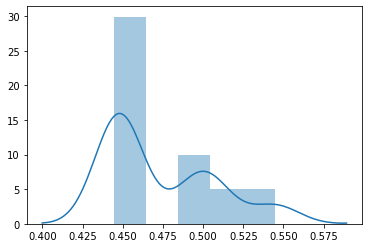

In [54]:
sns.distplot(y_predict)
plt.show()

In [55]:
plan_create['prob'] = y_predict

In [56]:
plan_create.shape

(80, 37)

In [62]:
plan_create

,ad_account_id,image_id,game_id,platform,android_osv,ios_osv,budget,retargeting_type,retargeting_tags_include,retargeting_tags_exclude,interest_action_mode,action_scene,action_days,action_categories,interest_categories,deep_bid_type,roi_goal,smart_bid_type,adjust_cpa,cpa_bid,delivery_range,city,location_type,gender,age,ac,launch_price,auto_extend_enabled,hide_if_exists,hide_if_converted,schedule_time,flow_control_mode,inventory_type,create_time,create_date,label_ids,prob,rank_ad_im
0,6987,31833,1001540,[ANDROID],NONE,NONE,3300,NONE,[],[],UNLIMITED,NaN,NaN,NaN,[],BID_PER_ACTION,NaN,SMART_BID_CUSTOM,0.0,756.0,DEFAULT,[],CURRENT,GENDER_MALE,[],[],"[0, 11000]",0,0,AD,0000000000000000000011111111111111111111111111...,FLOW_CONTROL_MODE_FAST,"[INVENTORY_HOTSOON_FEED, INVENTORY_TOMATO_NOVE...",2021-04-28 16:58:02.985602,2021-04-28,27,0.544705,1.0
1,6987,31833,1001540,[ANDROID],NONE,NONE,3300,NONE,[],[],UNLIMITED,NaN,NaN,NaN,[],BID_PER_ACTION,NaN,SMART_BID_CUSTOM,0.0,756.0,DEFAULT,[],CURRENT,GENDER_MALE,[],[],"[0, 11000]",0,0,AD,0000000000000000000011111111111111111111111111...,FLOW_CONTROL_MODE_FAST,"[INVENTORY_HOTSOON_FEED, INVENTORY_TOMATO_NOVE...",2021-04-28 16:58:02.985602,2021-04-28,27,0.544705,2.0
2,6987,31833,1001540,[ANDROID],NONE,NONE,3300,NONE,[],[],UNLIMITED,NaN,NaN,NaN,[],BID_PER_ACTION,NaN,SMART_BID_CUSTOM,0.0,756.0,DEFAULT,[],CURRENT,GENDER_MALE,[],[],"[0, 11000]",0,0,AD,0000000000000000000011111111111111111111111111...,FLOW_CONTROL_MODE_FAST,"[INVENTORY_HOTSOON_FEED, INVENTORY_TOMATO_NOVE...",2021-04-28 16:58:02.985602,2021-04-28,27,0.544705,3.0
3,6987,31833,1001540,[ANDROID],NONE,NONE,3300,NONE,[],[],UNLIMITED,NaN,NaN,NaN,[],BID_PER_ACTION,NaN,SMART_BID_CUSTOM,0.0,756.0,DEFAULT,[],CURRENT,GENDER_MALE,[],[],"[0, 11000]",0,0,AD,0000000000000000000011111111111111111111111111...,FLOW_CONTROL_MODE_FAST,"[INVENTORY_HOTSOON_FEED, INVENTORY_TOMATO_NOVE...",2021-04-28 16:58:02.985602,2021-04-28,27,0.544705,4.0
4,6987,31833,1001540,[ANDROID],NONE,NONE,3300,NONE,[],[],UNLIMITED,NaN,NaN,NaN,[],BID_PER_ACTION,NaN,SMART_BID_CUSTOM,0.0,756.0,DEFAULT,[],CURRENT,GENDER_MALE,[],[],"[0, 11000]",0,0,AD,0000000000000000000011111111111111111111111111...,FLOW_CONTROL_MODE_FAST,"[INVENTORY_HOTSOON_FEED, INVENTORY_TOMATO_NOVE...",2021-04-28 16:58:02.985602,2021-04-28,27,0.544705,5.0
5,6987,31833,1001540,[ANDROID],NONE,NONE,3300,NONE,[],[],UNLIMITED,NaN,NaN,NaN,[],BID_PER_ACTION,NaN,SMART_BID_CUSTOM,0.0,756.0,DEFAULT,[],CURRENT,GENDER_MALE,[],[],"[0, 11000]",0,0,AD,0000000000000000000011111111111111111111111111...,FLOW_CONTROL_MODE_FAST,"[INVENTORY_HOTSOON_FEED, INVENTORY_TOMATO_NOVE...",2021-04-28 16:58:02.985602,2021-04-28,27,0.544705,6.0
6,6987,31833,1001540,[ANDROID],NONE,NONE,3300,NONE,[],[],UNLIMITED,NaN,NaN,NaN,[],BID_PER_ACTION,NaN,SMART_BID_CUSTOM,0.0,756.0,DEFAULT,[],CURRENT,GENDER_MALE,[],[],"[0, 11000]",0,0,AD,0000000000000000000011111111111111111111111111...,FLOW_CONTROL_MODE_FAST,"[INVENTORY_HOTSOON_FEED, INVENTORY_TOMATO_NOVE...",2021-04-28 16:58:02.985602,2021-04-28,27,0.544705,7.0
7,6987,31833,1001540,[ANDROID],NONE,NONE,3300,NONE,[],[],UNLIMITED,NaN,NaN,NaN,[],BID_PER_ACTION,NaN,SMART_BID_CUSTOM,0.0,756.0,DEFAULT,[],CURRENT,GENDER_MALE,[],[],"[0, 11000]",0,0,AD,0000000000000000000011111111111111111111111111...,FLOW_CONTROL_MODE_FAST,"[INVENTORY_HOTSOON_FEED, INVENTORY_TOMATO_NOVE...",2021-04-28 16:58:02.985602,2021-04-28,27,0.544705,8.0
8,6988,31833,1001540,[ANDROID],NONE,NONE,3300,NONE,[],[],UNLIMITED,NaN,NaN,NaN,[],BID_PER_ACTION,NaN,SMART_BID_CUSTOM,0.0,756.0,DEFAULT,[],CURRENT,GENDER_MALE,[],[],"[0, 11000]",0,0,AD,0000000000000000000011111111111111111111111111...,FLOW_CONTROL_MODE_FAST,"[INVENTORY_HOTSOON_FEED, INVENTORY_TOMATO_NOVE...",2021-04-28 16:58:02.985602,2021-04-28,27,0.447297,1.0
9,6988,31833,1001540,[ANDROID],NONE,NONE,3300,NONE,[],[],UNLIMITED,NaN,NaN,NaN,[],BID_PER_ACTION,NaN,SMART_BID_CUSTOM,0.0,756.0,DEFAULT,[],CURRENT,GENDER_MALE,[],[],"[0, 11000]",0,0,AD,0000000000000000000011111111111111111111111111...,FL

In [61]:
plan_create['rank_ad_im'] = plan_create.groupby(['ad_account_id','image_id','game_id'])['prob'].rank(ascending=False,method='first')

In [63]:
plan_result = plan_create[plan_create['rank_ad_im']<=1]

In [65]:
plan_result

,ad_account_id,image_id,game_id,platform,android_osv,ios_osv,budget,retargeting_type,retargeting_tags_include,retargeting_tags_exclude,interest_action_mode,action_scene,action_days,action_categories,interest_categories,deep_bid_type,roi_goal,smart_bid_type,adjust_cpa,cpa_bid,delivery_range,city,location_type,gender,age,ac,launch_price,auto_extend_enabled,hide_if_exists,hide_if_converted,schedule_time,flow_control_mode,inventory_type,create_time,create_date,label_ids,prob,rank_ad_im
0,6987,31833,1001540,[ANDROID],NONE,NONE,3300,NONE,[],[],UNLIMITED,NaN,NaN,NaN,[],BID_PER_ACTION,NaN,SMART_BID_CUSTOM,0.0,756.0,DEFAULT,[],CURRENT,GENDER_MALE,[],[],"[0, 11000]",0,0,AD,0000000000000000000011111111111111111111111111...,FLOW_CONTROL_MODE_FAST,"[INVENTORY_HOTSOON_FEED, INVENTORY_TOMATO_NOVE...",2021-04-28 16:58:02.985602,2021-04-28,27,0.544705,1.0
8,6988,31833,1001540,[ANDROID],NONE,NONE,3300,NONE,[],[],UNLIMITED,NaN,NaN,NaN,[],BID_PER_ACTION,NaN,SMART_BID_CUSTOM,0.0,756.0,DEFAULT,[],CURRENT,GENDER_MALE,[],[],"[0, 11000]",0,0,AD,0000000000000000000011111111111111111111111111...,FLOW_CONTROL_MODE_FAST,"[INVENTORY_HOTSOON_FEED, INVENTORY_TOMATO_NOVE...",2021-04-28 16:58:02.985602,2021-04-28,27,0.447297,1.0
16,6989,31833,1001540,[ANDROID],NONE,NONE,3300,NONE,[],[],UNLIMITED,NaN,NaN,NaN,[],BID_PER_ACTION,NaN,SMART_BID_CUSTOM,0.0,756.0,DEFAULT,[],CURRENT,GENDER_MALE,[],[],"[0, 11000]",0,0,AD,0000000000000000000011111111111111111111111111...,FLOW_CONTROL_MODE_FAST,"[INVENTORY_HOTSOON_FEED, INVENTORY_TOMATO_NOVE...",2021-04-28 16:58:02.985602,2021-04-28,27,0.500146,1.0
24,6990,31833,1001540,[ANDROID],NONE,NONE,3300,NONE,[],[],UNLIMITED,NaN,NaN,NaN,[],BID_PER_ACTION,NaN,SMART_BID_CUSTOM,0.0,756.0,DEFAULT,[],CURRENT,GENDER_MALE,[],[],"[0, 11000]",0,0,AD,0000000000000000000011111111111111111111111111...,FLOW_CONTROL_MODE_FAST,"[INVENTORY_HOTSOON_FEED, INVENTORY_TOMATO_NOVE...",2021-04-28 16:58:02.985602,2021-04-28,27,0.506486,1.0
32,6867,31833,1001540,[ANDROID],NONE,NONE,3300,NONE,[],[],UNLIMITED,NaN,NaN,NaN,[],BID_PER_ACTION,NaN,SMART_BID_CUSTOM,0.0,756.0,DEFAULT,[],CURRENT,GENDER_MALE,[],[],"[0, 11000]",0,0,AD,0000000000000000000011111111111111111111111111...,FLOW_CONTROL_MODE_FAST,"[INVENTORY_HOTSOON_FEED, INVENTORY_TOMATO_NOVE...",2021-04-28 16:58:02.985602,2021-04-28,27,0.450635,1.0
40,6868,31833,1001540,[ANDROID],NONE,NONE,3300,NONE,[],[],UNLIMITED,NaN,NaN,NaN,[],BID_PER_ACTION,NaN,SMART_BID_CUSTOM,0.0,756.0,DEFAULT,[],CURRENT,GENDER_MALE,[],[],"[0, 11000]",0,0,AD,0000000000000000000011111111111111111111111111...,FLOW_CONTROL_MODE_FAST,"[INVENTORY_HOTSOON_FEED, INVENTORY_TOMATO_NOVE...",2021-04-28 16:58:02.985602,2021-04-28,27,0.493507,1.0
48,7323,31833,1001540,[ANDROID],NONE,NONE,3300,NONE,[],[],UNLIMITED,NaN,NaN,NaN,[],BID_PER_ACTION,NaN,SMART_BID_CUSTOM,0.0,756.0,DEFAULT,[],CURRENT,GENDER_MALE,[],[],"[0, 11000]",0,0,AD,0000000000000000000011111111111111111111111111...,FLOW_CONTROL_MODE_FAST,"[INVENTORY_HOTSOON_FEED, INVENTORY_TOMATO_NOVE...",2021-04-28 16:58:02.985602,2021-04-28,27,0.447297,1.0
56,7324,31833,1001540,[ANDROID],NONE,NONE,3300,NONE,[],[],UNLIMITED,NaN,NaN,NaN,[],BID_PER_ACTION,NaN,SMART_BID_CUSTOM,0.0,756.0,DEFAULT,[],CURRENT,GENDER_MALE,[],[],"[0, 11000]",0,0,AD,0000000000000000000011111111111111111111111111...,FLOW_CONTROL_MODE_FAST,"[INVENTORY_HOTSOON_FEED, INVENTORY_TOMATO_NOVE...",2021-04-28 16:58:02.985602,2021-04-28,27,0.447297,1.0
64,7325,31833,1001540,[ANDROID],NONE,NONE,3300,NONE,[],[],UNLIMITED,NaN,NaN,NaN,[],BID_PER_ACTION,NaN,SMART_BID_CUSTOM,0.0,756.0,DEFAULT,[],CURRENT,GENDER_MALE,[],[],"[0, 11000]",0,0,AD,0000000000000000000011111111111111111111111111...,FLOW_CONTROL_MODE_FAST,"[INVENTORY_HOTSOON_FEED, INVENTORY_TOMATO_NOVE...",2021-04-28 16:58:02.985602,2021-04-28,27,0.447297,1.0
77,7326,31833,1001540,[ANDROID],NONE,NONE,3300,NONE,[],[],UNLIMITED,NaN,NaN,NaN,[],BID_PER_ACTION,NaN,SMART_BID_CUSTOM,0.0,756.0,DEFAULT,[],CURRENT,GENDER_MALE,[],[],"[0, 11000]",0,0,AD,00000000000000000000111111111111111111111111

In [ ]:
plan_result['']

In [271]:
plan_create.shape

(160, 37)

In [138]:
plan_result = plan_create[plan_create['prob']>=threshold]

In [139]:
plan_result.shape

(97, 38)

In [140]:
plan_result['ad_account_id'].value_counts()

6990    11
7323    11
6989    10
6988    10
7326    10
7325    10
7324    10
6987     9
6868     8
6867     8
Name: ad_account_id, dtype: int64

In [141]:
plan_result['rank_ad_im'] = plan_result.groupby(['ad_account_id','image_id'])['prob'].rank(ascending=False)
# plan_result['rank_ad'] = plan_result.groupby(['ad_account_id'])['prob'].rank(ascending=False)
# plan_result['rank_im'] = plan_result.groupby(['image_id'])['prob'].rank(ascending=False)

C:\Users\Administrator\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [142]:
plan_result = plan_result[plan_result['rank_ad_im']<=1]

In [143]:
plan_result['ad_account_id'].value_counts()

7324    2
6990    2
6988    2
7323    2
7326    2
6989    1
6987    1
7325    1
6868    1
6867    1
Name: ad_account_id, dtype: int64

In [144]:
plan_create['rank_ad_im'] = plan_create.groupby(['ad_account_id', 'image_id'])['prob'].rank(ascending=False)

In [145]:
plan_result_pr = plan_create[plan_create['rank_ad_im'] <= 1]

In [146]:
ad_num = plan_result['ad_account_id'].value_counts()
for ad in np.setdiff1d(plan_create['ad_account_id'].values, ad_num[ad_num > 2].index):
    add_plan = plan_result_pr[plan_result_pr['ad_account_id'] == ad].sort_values('prob', ascending=False)[0:2]
    plan_result = plan_result.append(add_plan)

plan_result = plan_result.drop(['create_time', 'create_date', 'prob', 'rank_ad_im', 'label_ids'], axis=1)

In [147]:
plan_result['image_id'].value_counts()

31833    16
31363    15
Name: image_id, dtype: int64